In [3]:
from importlib import reload

from src.data import make_dataset

from src.models import config
config = reload(config)
from src.models.unet import UNet
from src.models.train_model import Trainer

from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.optim import Adam
import torch

import albumentations as A

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import segmentation_models_pytorch as smp

## DATA
# Load train images
trainImages = config.train_orange_3_doors_images + config.train_black_5_doors_images

# Split images into train and val
train_dataset, val_dataset = random_split(trainImages, [1-config.VAL_SPLIT,config.VAL_SPLIT])
print(f"Dataset length: {len(trainImages)}")
print(f"Validation length: {len(val_dataset)}")
print(f"Train length: {len(train_dataset)}")

# define transformations
testTransform = A.Compose(
    [A.Resize(config.INPUT_IMAGE_HEIGHT, config.INPUT_IMAGE_WIDTH),
     #A.ToGray(p=1)
    ]
)

ShiftDic = {
    'y' : (0.3,0.5)
}

trainTransform = A.Compose(
    [
        A.Resize(config.INPUT_IMAGE_HEIGHT, config.INPUT_IMAGE_WIDTH),
        A.RandomBrightnessContrast(brightness_limit=(0,0.10), contrast_limit=0.10, p=0.5),
        A.ChannelShuffle(p=0.5),
        A.Affine(translate_percent=ShiftDic,always_apply=True),
        A.Affine(scale=(0.7,1), rotate=(-25,25), shear=0, p=0.5),
    ]
)

# create the train and val datasets
train_DS = make_dataset.imageArrayDataset(arrayPaths=train_dataset, #train_dataset
                                          bgPaths=config.background_images, 
                                          transforms=trainTransform)

val_DS = make_dataset.imageArrayDataset(arrayPaths=val_dataset,
                                        bgPaths=config.background_images, 
                                        transforms=testTransform)

test_DS = make_dataset.imageArrayDataset(arrayPaths=config.test_images,
                                         bgPaths=config.background_images, 
                                         transforms=testTransform, 
                                         test=True)

# create the training and val data loaders
trainLoader = DataLoader(train_DS, shuffle=True,
	batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY,
	num_workers=config.NUM_WORKERS)
valLoader = DataLoader(val_DS, shuffle=False,
	batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY,
	num_workers=config.NUM_WORKERS)
testLoader = DataLoader(test_DS, shuffle=False,
	batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY,
	num_workers=config.NUM_WORKERS)

imageLoad, maskLoad = next(iter(trainLoader))
imageLoad, maskLoad = imageLoad.to(config.DEVICE), maskLoad.to(config.DEVICE)

print(imageLoad.shape, maskLoad.shape, type(imageLoad), type(maskLoad), imageLoad.dtype, maskLoad.dtype)
print(torch.unique(maskLoad))


## TRAIN MODELS
#DEFINE MODELS

#unet
#Unet_scratch = UNet().to(config.DEVICE)
Unet_scratch = smp.Unet(
    encoder_name="resnet101",
    encoder_weights="imagenet",
    in_channels=3,
    classes = 10
)

#Deepnet
Deep18 = smp.DeepLabV3Plus(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=3,
    classes=10,
)
Deep50 = smp.DeepLabV3Plus(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=10,
)
Deep101 = smp.DeepLabV3Plus(
    encoder_name="resnet101",
    encoder_weights="imagenet",
    in_channels=3,
    classes=10,
)

#DEFINE TRAINERS
alpha_ = 0.4
beta_ = 0.6
criterion1 = smp.losses.FocalLoss(mode="multiclass")
criterion2 = smp.losses.DiceLoss(mode="multiclass")

opt_Unet = Adam(Unet_scratch.parameters(), lr=0.10e-4,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
trainer_Unet = Trainer(
    model=Unet_scratch, 
    criterion1=criterion1,
    criterion2=criterion2,
    testLoader=testLoader,
    optimizer=opt_Unet,
    device=config.DEVICE,
    modelPath="Models/UNET/",
    alpha=alpha_, #criterion1*alpha + criterion2*beta
    beta=beta_
)

opt_deep18 = Adam(Deep18.parameters(), lr=0.1e-4,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
trainer_deep18 = Trainer(
    model=Deep18, 
    criterion1=criterion1,
    criterion2=criterion2,
    testLoader=testLoader,
    optimizer=opt_deep18,
    device=config.DEVICE,
    modelPath="Models/Deeplabv3/Resnet18/",
    alpha=alpha_, #criterion1*alpha + criterion2*beta
    beta=beta_
)

opt_deep50 = Adam(Deep50.parameters(), lr=0.1e-4,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
trainer_deep50 = Trainer(
    model=Deep50, 
    criterion1=criterion1,
    criterion2=criterion2,
    testLoader=testLoader,
    optimizer=opt_deep50,
    device=config.DEVICE,
    modelPath="Models/Deeplabv3/Resnet50/",
    alpha=alpha_, #criterion1*alpha + criterion2*beta
    beta=beta_
)

opt_deep101 = Adam(Deep101.parameters(), lr=0.1e-4,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
trainer_deep101 = Trainer(
    model=Deep101, 
    criterion1=criterion1,
    criterion2=criterion2,
    testLoader=testLoader,
    optimizer=opt_deep101,
    device=config.DEVICE,
    modelPath="Models/Deeplabv3/Resnet101/",
    alpha=alpha_, #criterion1*alpha + criterion2*beta
    beta=beta_
)


#FIT TRAINERS
NUM_EPOCH = 30 #20 epochs is about 1hour-2hour depends on gpu
torch.cuda.empty_cache()

trainer_Unet.fit(
    train_loader=trainLoader,
    val_loader=valLoader,
    epochs=NUM_EPOCH,
    patience=3)

torch.cuda.empty_cache()

trainer_deep18.fit(
    train_loader=trainLoader,
    val_loader=valLoader,
    epochs=NUM_EPOCH,
    patience=3)

torch.cuda.empty_cache()

trainer_deep50.fit(
    train_loader=trainLoader,
    val_loader=valLoader,
    epochs=NUM_EPOCH,
    patience=3)

torch.cuda.empty_cache()

trainer_deep101.fit(
    train_loader=trainLoader,
    val_loader=valLoader,
    epochs=NUM_EPOCH,
    patience=3)

torch.cuda.empty_cache()



Dataset length: 2833
Validation length: 28
Train length: 2805
torch.Size([16, 3, 256, 256]) torch.Size([16, 256, 256]) <class 'torch.Tensor'> <class 'torch.Tensor'> torch.float32 torch.int64
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')


Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/xception-43020ad28.pth" to C:\Users\uller/.cache\torch\hub\checkpoints\xception-43020ad28.pth


URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1129)>

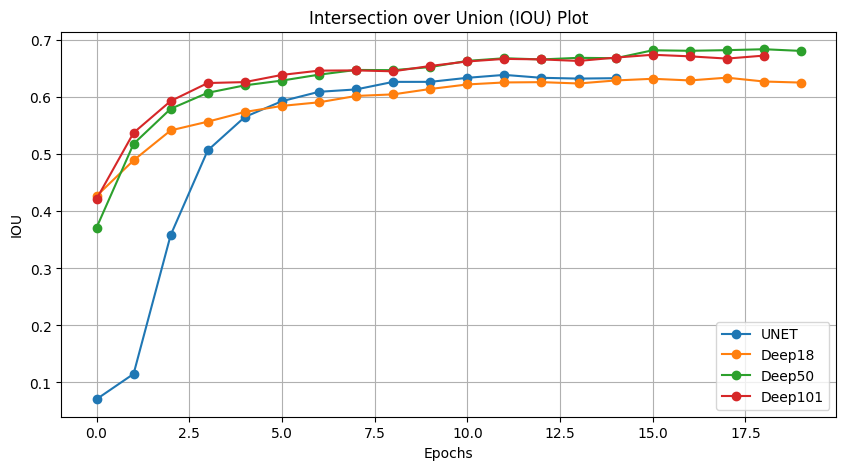

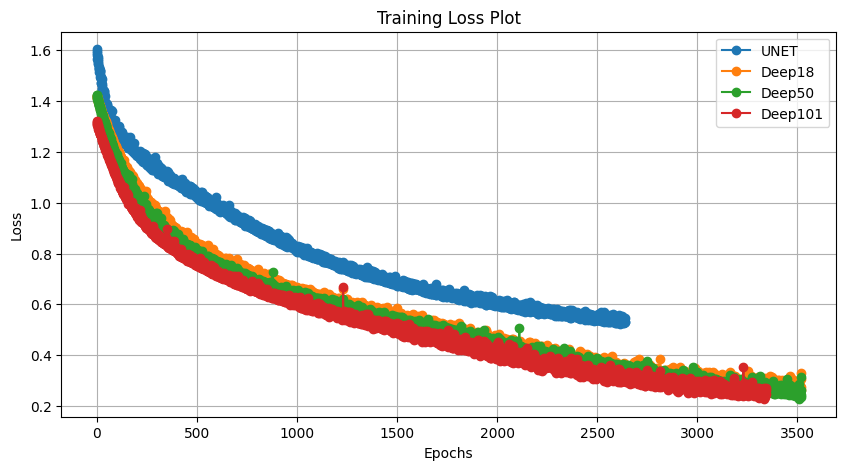

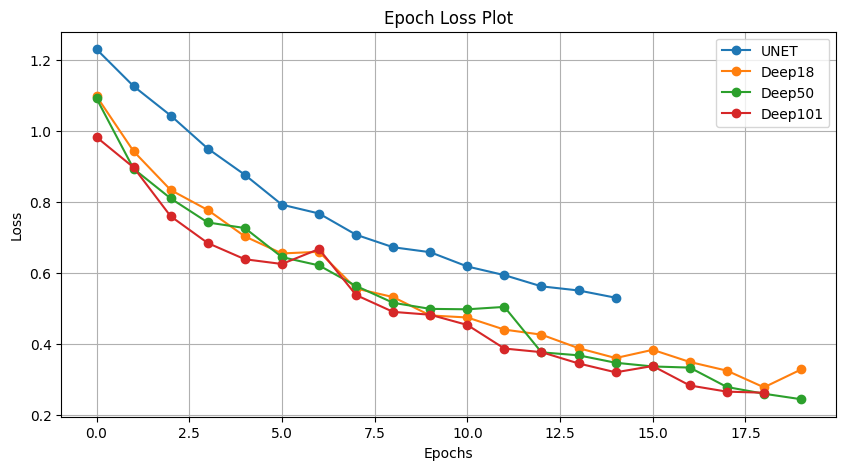

In [5]:
epochs_1 = range(0,15)
epochs_2 = range(0,20)
epochs_3 = range(0,20)
epochs_4 = range(0,19)

Model_name_1 = "UNET"
Model_name_2 = "Deep18"
Model_name_3 = "Deep50"
Model_name_4 = "Deep101"

# IOU plot for four models
plt.figure(figsize=(10, 5))
plt.plot(epochs_1, trainer_Unet.IOU_score, marker='o', label=Model_name_1)
plt.plot(epochs_2, trainer_deep18.IOU_score, marker='o', label=Model_name_2)
plt.plot(epochs_3, trainer_deep50.IOU_score, marker='o', label=Model_name_3)
plt.plot(epochs_4, trainer_deep101.IOU_score, marker='o', label=Model_name_4)
plt.title('Intersection over Union (IOU) Plot')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.grid(True)
plt.show()

# Training Loss plot for four models
plt.figure(figsize=(10, 5))
plt.plot(trainer_Unet.train_step_loss, marker='o', label=Model_name_1)
plt.plot(trainer_deep18.train_step_loss, marker='o', label=Model_name_2)
plt.plot(trainer_deep50.train_step_loss, marker='o', label=Model_name_3)
plt.plot(trainer_deep101.train_step_loss, marker='o', label=Model_name_4)
plt.title('Training Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Epoch Loss plot for four models
plt.figure(figsize=(10, 5))
plt.plot(epochs_1, trainer_Unet.train_loss_, marker='o', label=Model_name_1)
plt.plot(epochs_2, trainer_deep18.train_loss_, marker='o', label=Model_name_2)
plt.plot(epochs_3, trainer_deep50.train_loss_, marker='o', label=Model_name_3)
plt.plot(epochs_4, trainer_deep101.train_loss_, marker='o', label=Model_name_4)
plt.title('Epoch Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()